# About Dataset
**Description:**
Lyft, Inc. is a transportation network company based in San Francisco, California and operating in 640 cities in the United States and 9 cities in Canada. It develops, markets, and operates the Lyft mobile app, offering car rides, scooters, and a bicycle-sharing system. It is the second largest rideshare company in the world, second to only Uber.
Lyft’s bike-sharing service is also among the largest in the USA. Being able to anticipate demand is extremely important for planning of bicycles, stations, and the personnel required to maintain these. This demand is sensitive to a lot of factors like season, humidity, rain, weekdays, holidays, and more. To enable this planning, Lyft needs to rightly predict the demand according to these factors

**Data Description:**
The variables present in the dataset are:

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Imports and reading data

In [1]:
import os
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

plt.style.use('fivethirtyeight')

In [2]:
DIR = 'Lyftdataset'
file_path = os.path.join(DIR,'Lyftdataset.csv')
df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')

In [3]:
df

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
...                     ...      ...         ...      ...    ...     ...   
2012-12-19 19:00:00       4        0           1        1  15.58  19.695   
2012-12-19 20:00:00       4        0           1        1  14.76  17.425   
2012-12-19 21:00:00       4        0           1        1  13.94  15.910   
2012-12-19 22:00:00       4        0           1        1  13.94  17.425   
2012-12-19 23:00:00       4        0           1        1  13.12  16.665   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81     0.0000       3          13     16  
2011-01-01 01:00:00        80     0.0000       8          32     40  
2011-01-01 02:00:00        80     0.0000       5          27     32  
2011-01-01 03:00:00        75     0.0000       3          10     13  
2011-01-01 04:00:00        75     0.0000       0           1      1  
...                       ...        ...     ...         ...    ...  
2012-12-19 19:00:00        50    26.0027       7         329    336  
2012-12-19 20:00:00        57    15.0013      10         231    241  
2012-12-19 21:00:00        61    15.0013       4         164    168  
2012-12-19 22:00:00        61     6.0032      12         117    129  
2012-12-19 23:00:00        66     8.9981       4          84     88  

[10886 rows x 11 columns]

# Understanding data

In [4]:
df.shape

(10886, 11)

In [5]:
# Information on data types and count
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [6]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [7]:
# Description of the data in basic statistics
df.describe().T 

count        mean         std   min      25%      50%       75%  \
season      10886.0    2.506614    1.116174  1.00   2.0000    3.000    4.0000   
holiday     10886.0    0.028569    0.166599  0.00   0.0000    0.000    0.0000   
workingday  10886.0    0.680875    0.466159  0.00   0.0000    1.000    1.0000   
weather     10886.0    1.418427    0.633839  1.00   1.0000    1.000    2.0000   
temp        10886.0   20.230860    7.791590  0.82  13.9400   20.500   26.2400   
atemp       10886.0   23.655084    8.474601  0.76  16.6650   24.240   31.0600   
humidity    10886.0   61.886460   19.245033  0.00  47.0000   62.000   77.0000   
windspeed   10886.0   12.799395    8.164537  0.00   7.0015   12.998   16.9979   
casual      10886.0   36.021955   49.960477  0.00   4.0000   17.000   49.0000   
registered  10886.0  155.552177  151.039033  0.00  36.0000  118.000  222.0000   
count       10886.0  191.574132  181.144454  1.00  42.0000  145.000  284.0000   

                 max  
season        4.0000  
holiday       1.0000  
workingday    1.0000  
weather       4.0000  
temp         41.0000  
atemp        45.4550  
humidity    100.0000  
windspeed    56.9969  
casual      367.0000  
registered  886.0000  
count       977.0000

# Baseline model training

In [8]:
base_df = df.copy()
base_df.drop(['casual','registered'],axis=1, inplace=True)
base_train = base_df[df.index < '2012-06-01']
base_test = base_df[df.index >= '2012-06-01']

base_X_train = base_train.drop('count', axis=1)
base_y_train = base_train['count']
base_X_test = base_test.drop('count', axis=1)
base_y_test = base_test['count']

base_xgb = xgb.XGBRegressor()
base_xgb.fit(base_X_train, base_y_train)

y_hat_train = base_xgb.predict(base_X_train)
y_hat_test = base_xgb.predict(base_X_test)

print(f'MAE: {mean_absolute_error(base_y_train, y_hat_train)}')
print(f'R2 score: {r2_score(base_y_train, y_hat_train)}')
print(f'MAE: {mean_absolute_error(base_y_test, y_hat_test)}')
print(f'R2 score: {r2_score(base_y_test, y_hat_test)}')

MAE: 64.39974774420843
R2 score: 0.6465552164587258
MAE: 151.13327540442774
R2 score: 0.08478218833483608


# Data preparation

In [9]:
# To see for missing values, no missing values
df.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [10]:
# No duplicate records found
df.duplicated().sum()

21

In [11]:
# Dropping irrelevent columns 
df.drop(['casual','registered'], axis=1, inplace=True)

In [12]:
# Season, weather and year dictionary
seasons = {
    1:'spring',
    2:'summer',
    3:'fall',
    4:'winter'
}

weathers = {
    1:'best',
    2:'better',
    3:'good',
    4:'worst'
}

In [13]:
df['season'] = df['season'].map(lambda x: seasons[x])
df['weather'] = df['weather'].map(lambda x: weathers[x])

In [14]:
# Feature creation
def date_feature_creation(df):
    """Feature creation from datetime index"""
    df_feature = df.copy()
    df_feature['hour'] = df_feature.index.hour
    df_feature['dayofmonth'] = df_feature.index.day
    df_feature['month'] = df_feature.index.month
    df_feature['year'] = df_feature.index.year
    df_feature['quarter'] = df_feature.index.quarter
    df_feature['weekofyear'] = df_feature.index.weekofyear
    df_feature['dayofyear'] = df_feature.index.dayofyear
    df_feature['dayofweek'] = df_feature.index.dayofweek

    return df_feature

In [15]:
df = date_feature_creation(df)

C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\2809620696.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_feature['weekofyear'] = df_feature.index.weekofyear


# Feature understanding

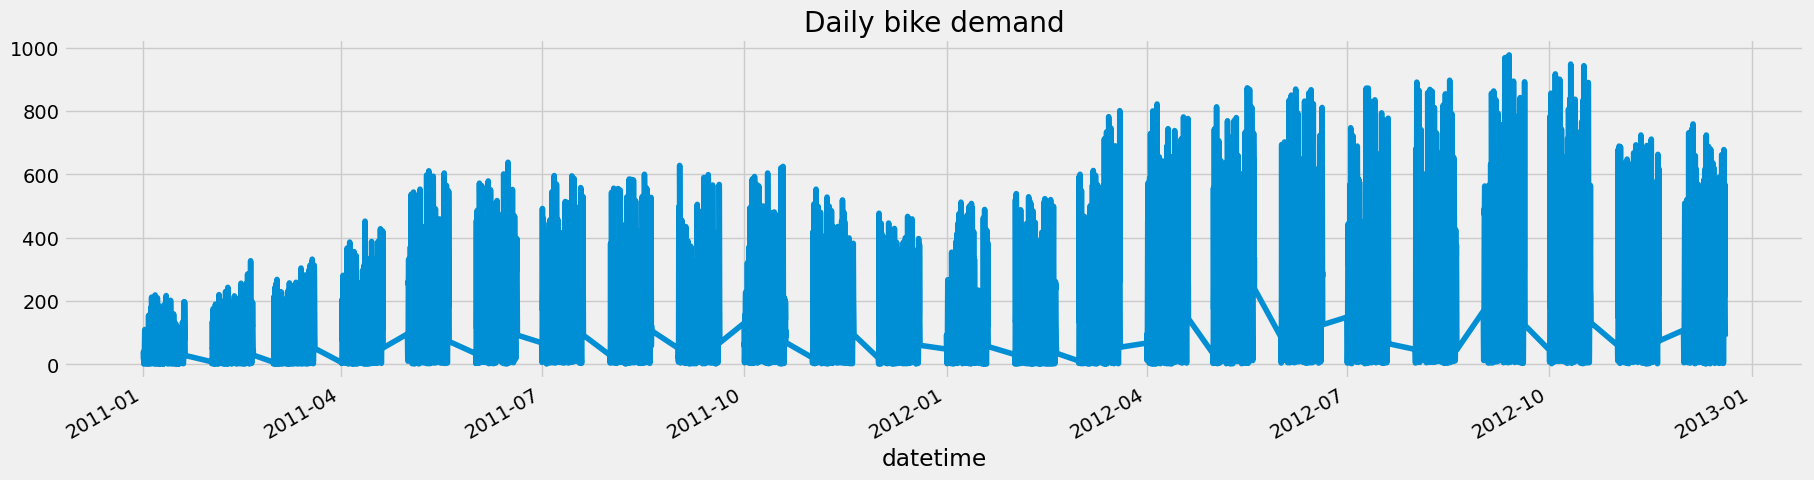

In [16]:
_ = df['count'].plot(style='-', figsize=(20,5), title='Daily bike demand')

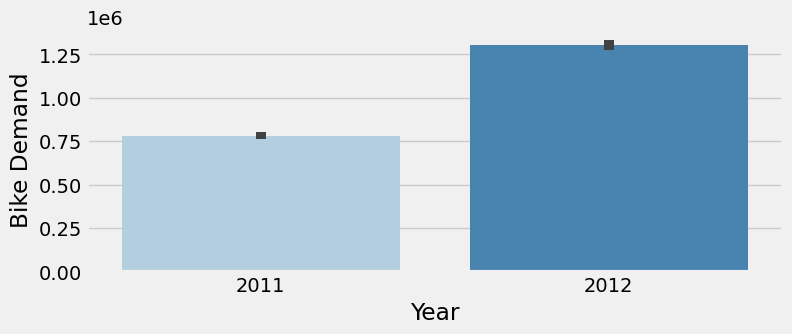

In [17]:
# ploting year vs. bike demand
plt.figure(figsize=(8,3))
ax = sns.barplot(x='year', y='count', data=df, palette='Blues', estimator=sum)
ax.set_xlabel('Year')
ax.set_ylabel('Bike Demand')
plt.show()

- Huge demand increase from 2011 to 2012

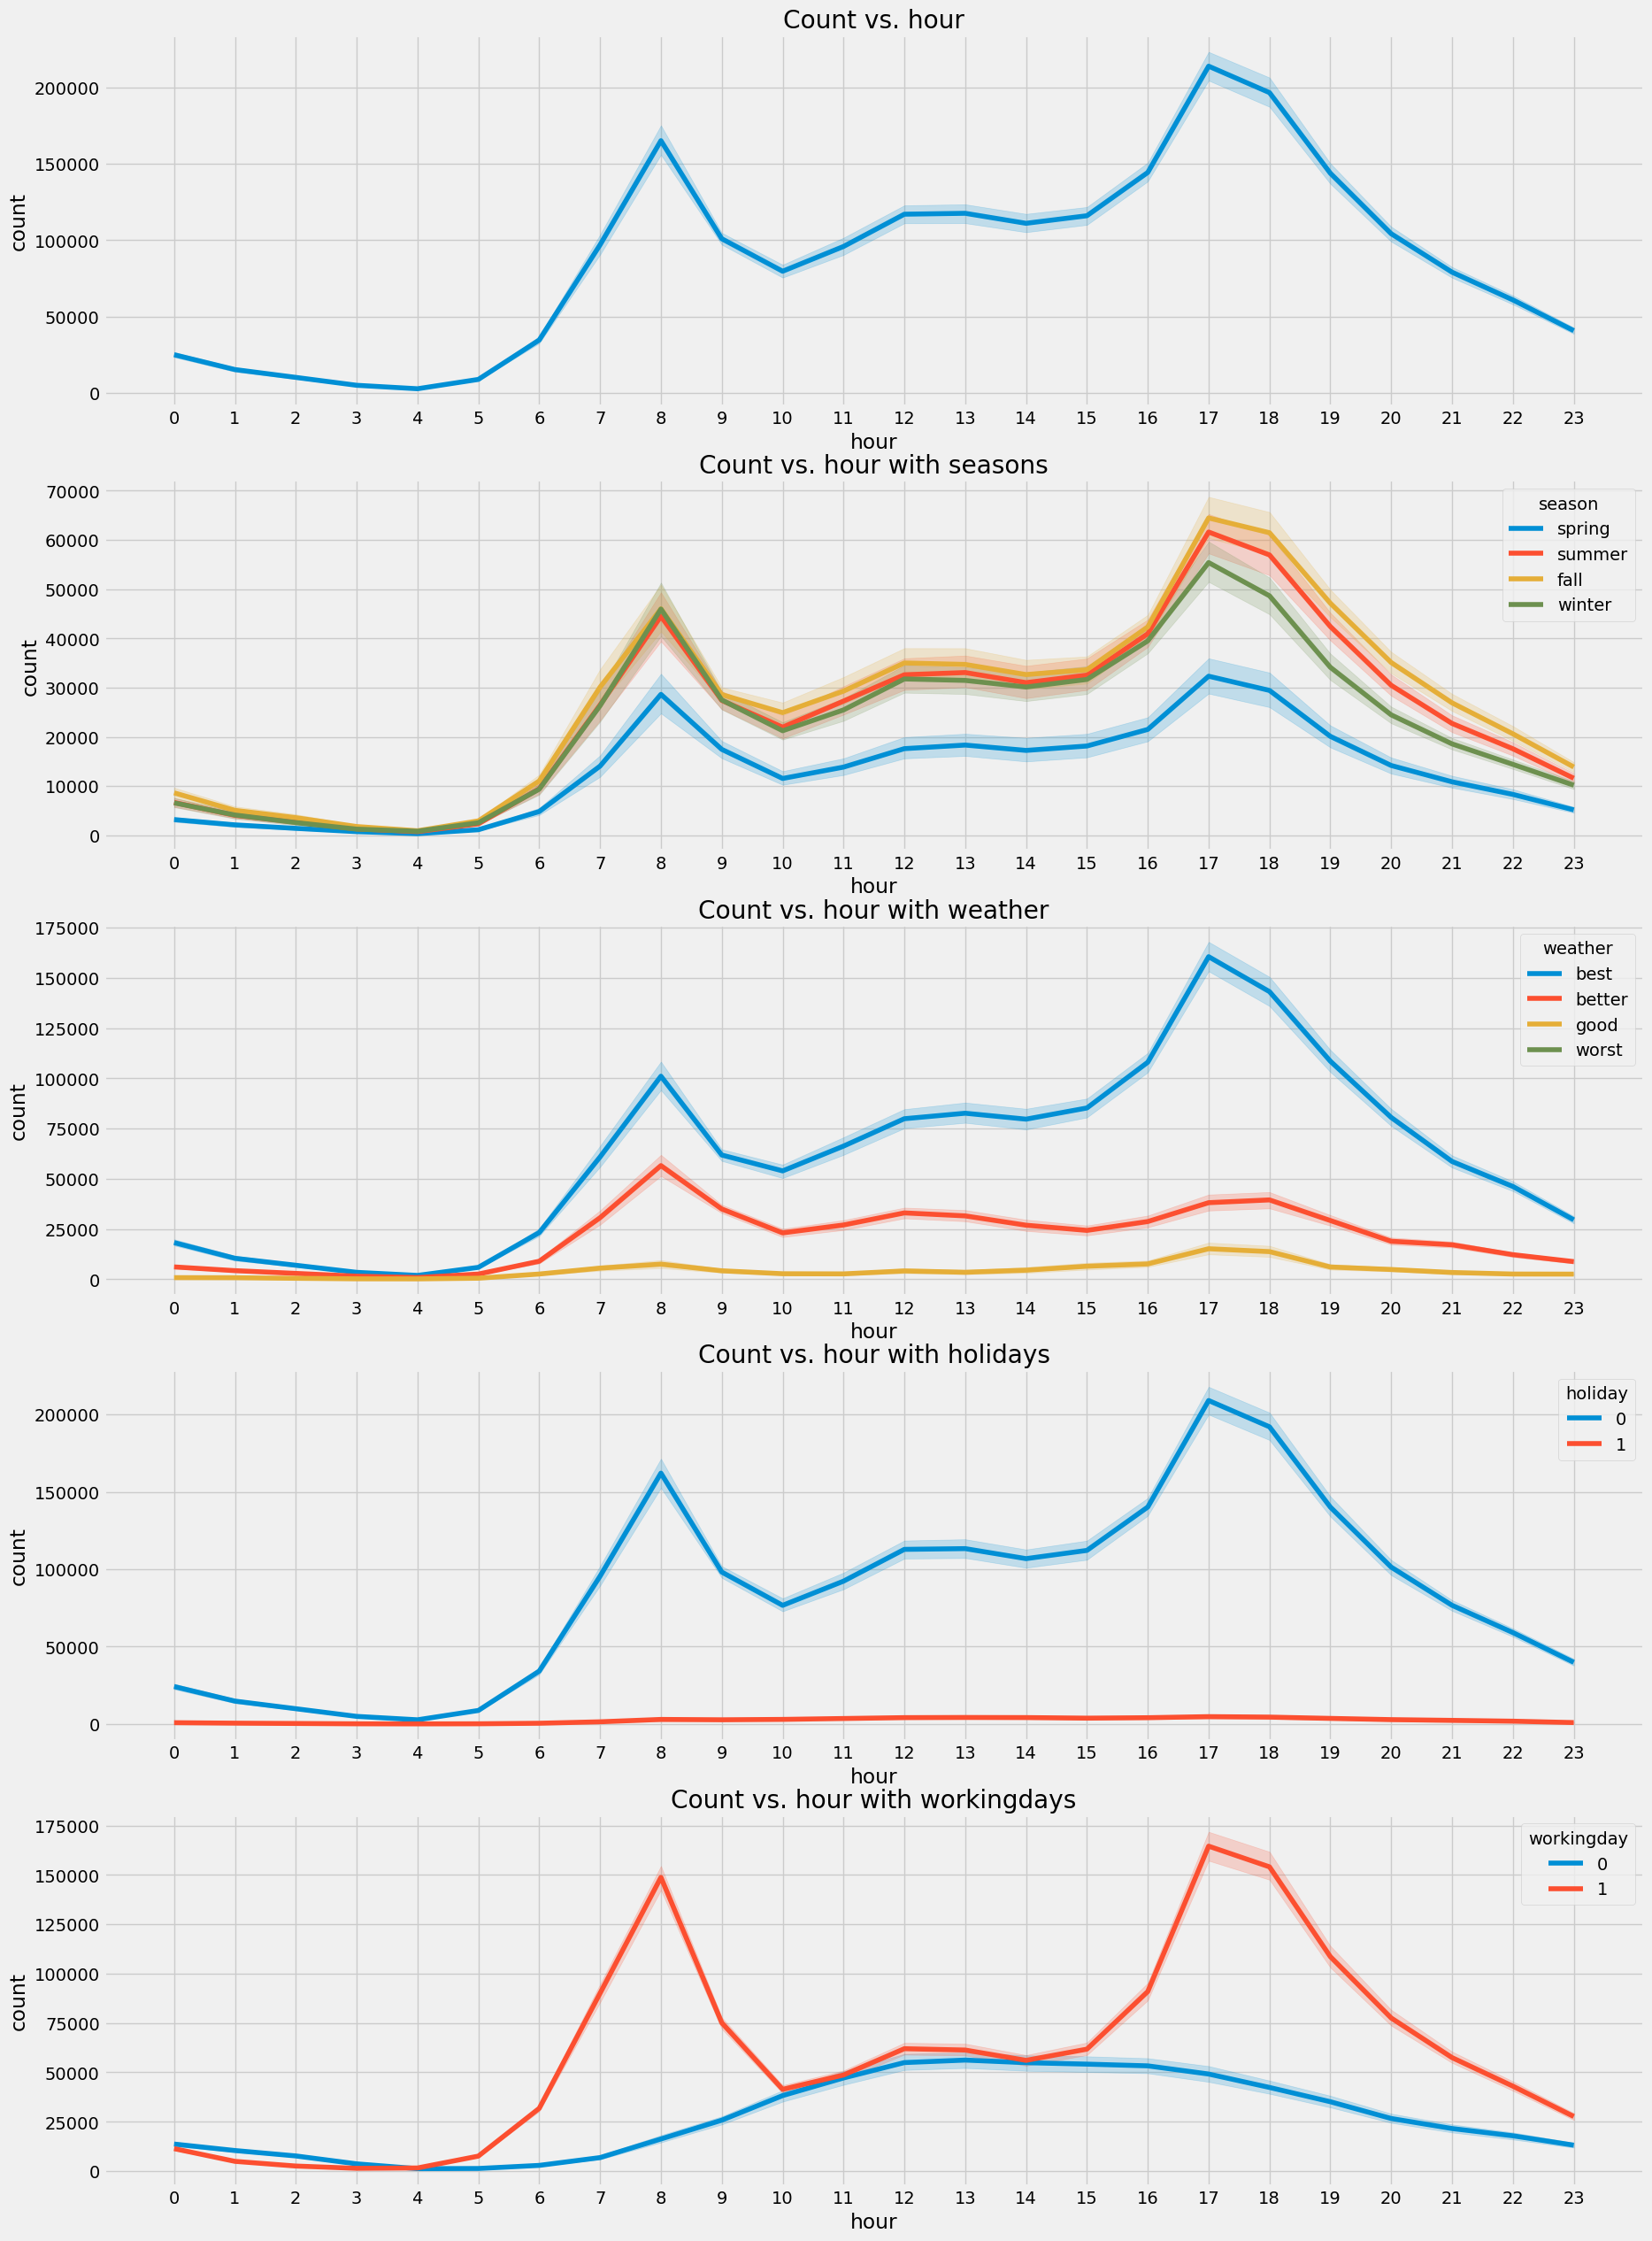

In [18]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,30))
sns.lineplot(data=df, x='hour', y='count', estimator=sum, ax=ax[0])
sns.lineplot(data=df, x='hour', y='count', estimator=sum, hue='season', ax=ax[1])
sns.lineplot(data=df, x='hour', y='count', estimator=sum, hue='weather', ax=ax[2])
sns.lineplot(data=df, x='hour', y='count', estimator=sum, hue='holiday', ax=ax[3])
sns.lineplot(data=df, x='hour', y='count', estimator=sum, hue='workingday', ax=ax[4])
ax[0].set_xticks(df['hour'].unique())
ax[0].set_title('Count vs. hour')
ax[1].set_xticks(df['hour'].unique())
ax[1].set_title('Count vs. hour with seasons')
ax[2].set_xticks(df['hour'].unique())
ax[2].set_title('Count vs. hour with weather')
ax[3].set_xticks(df['hour'].unique())
ax[3].set_title('Count vs. hour with holidays')
ax[4].set_xticks(df['hour'].unique())
ax[4].set_title('Count vs. hour with workingdays')
plt.show()

- Bike demand is high in morning at 8 AM and higest of the day at 5 PM, i.e., working people and school kids mostly use bike.

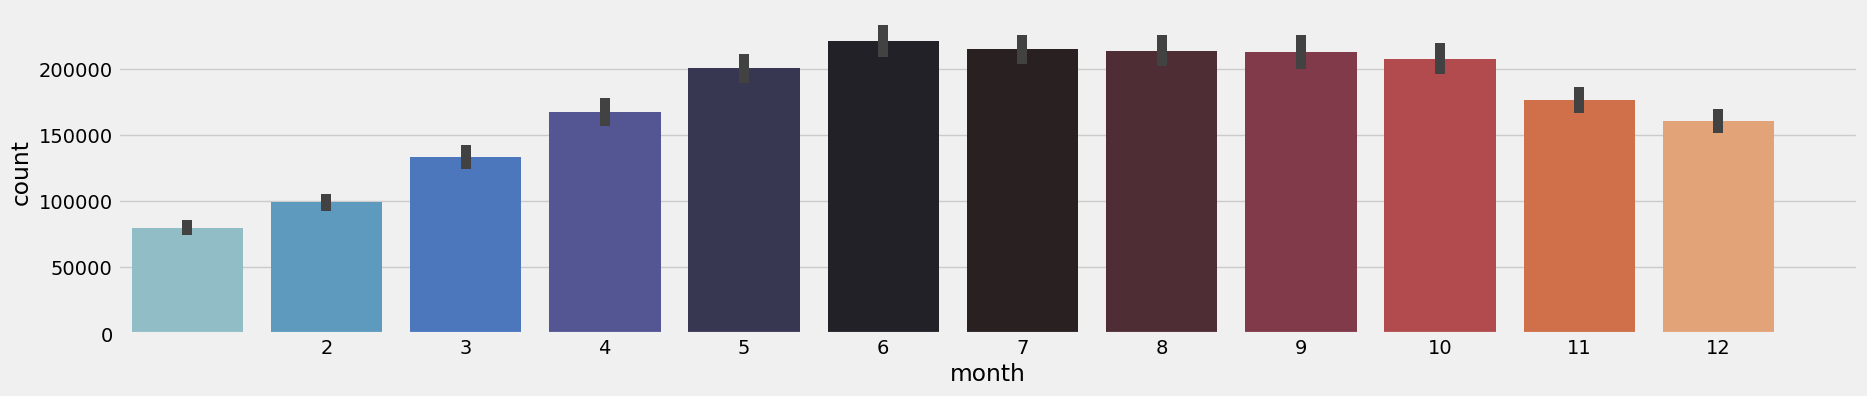

In [19]:
# plot of month vs. bike demand
plt.figure(figsize=(20,4))
ax = sns.barplot(x='month', y='count', data=df, palette='icefire', estimator=sum)
ax.set_xticks(df['month'].unique())
plt.show()

- Demand is higest in the month of June, July, August and September.

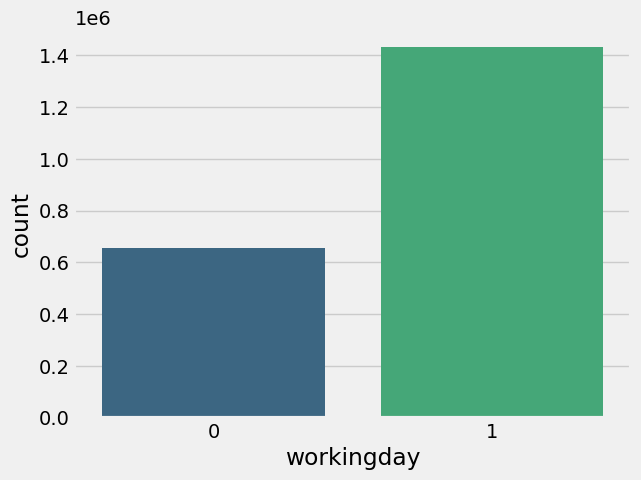

In [20]:
# Plot between weekday vs. count
_ = sns.barplot(x='workingday', y='count', data=df, ci=None, palette='viridis', estimator=sum)

- Demand is high on weekdays and decreases on sunday.

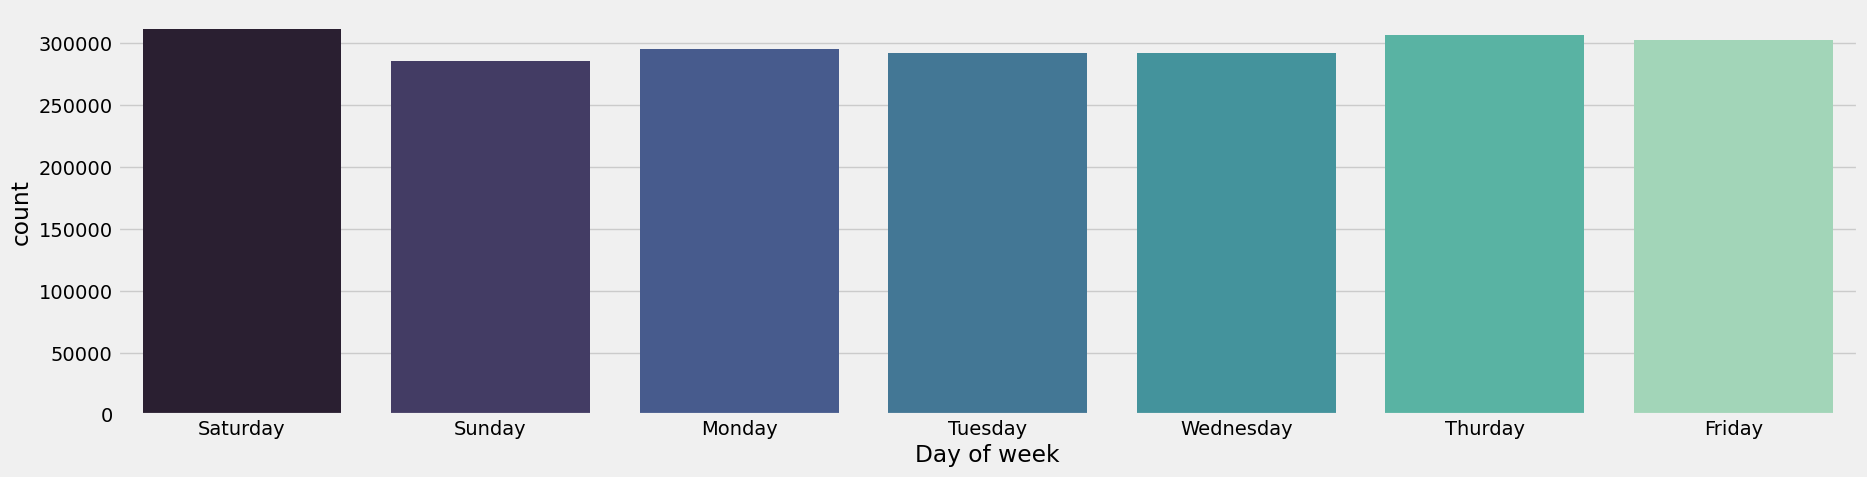

In [21]:
# plot of day of week vs. count
weekday={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thurday',4:'Friday',5:'Saturday',6:'Sunday'}
df['day_name'] = df['dayofweek'].map(weekday)
plt.figure(figsize=(20,5))
ax = sns.barplot(x='day_name', y='count', data=df, ci=None, palette='mako', estimator=sum)
ax.set_xlabel('Day of week')
plt.show()

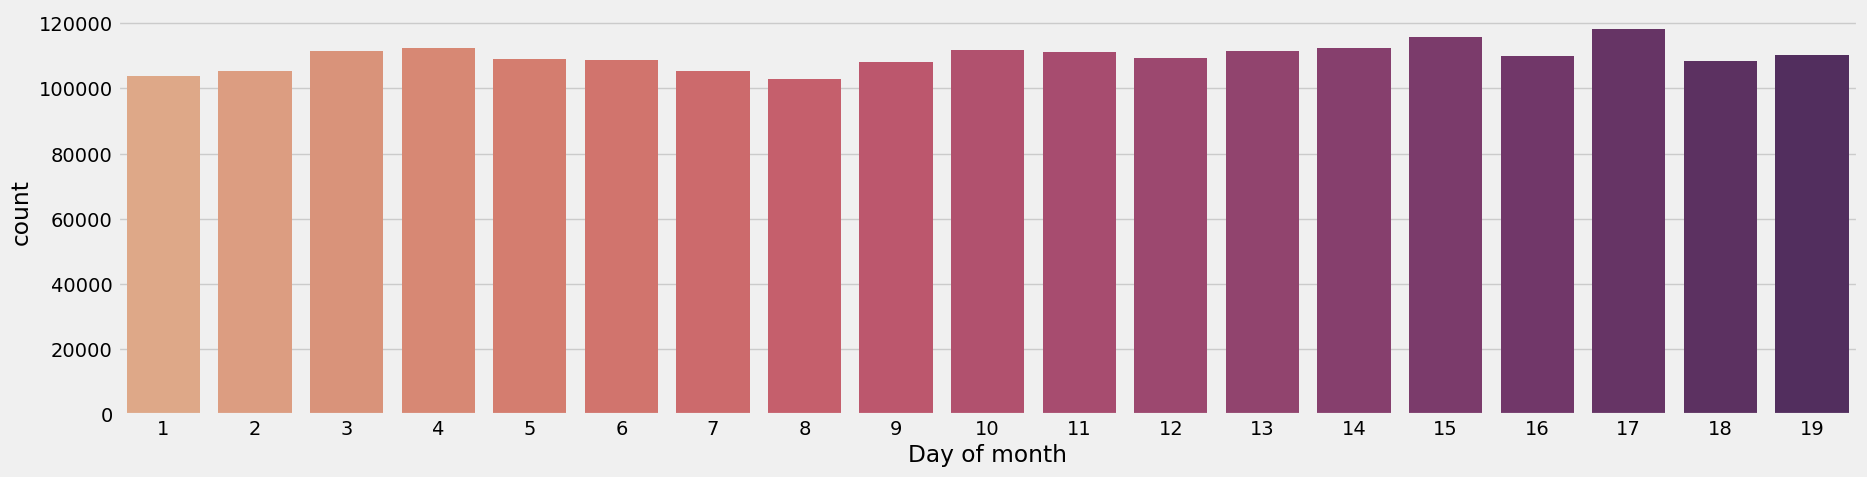

In [22]:
# plot of month of day vs. count
plt.figure(figsize=(20,5))
ax = sns.barplot(x='dayofmonth', y='count', data=df, ci=None, palette='flare', estimator=sum)
ax.set_xlabel('Day of month')
plt.show()

- Day 5th to 10th showing high demand.

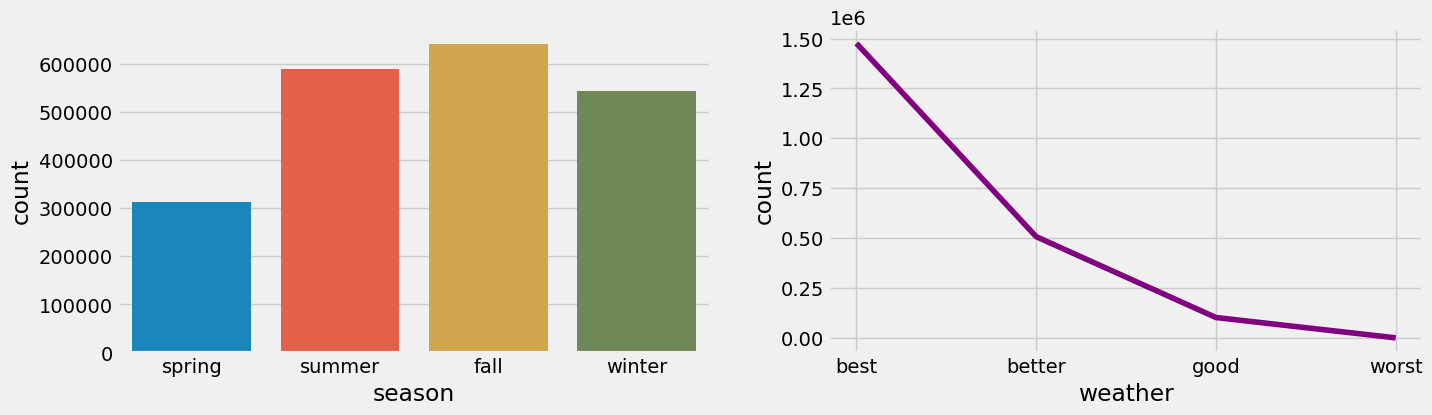

In [23]:
# plot for season vs. demand and weather condition vs. demand
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x='season', y='count', data=df, ci=None, ax=ax1, estimator=sum)
sns.lineplot(x='weather', y='count', data=df.reset_index(), ci=None, ax=ax2, color='purple', estimator=sum)
plt.show()

- Fall season has higest demand.
- Also, obviously Best weather has higest demand.

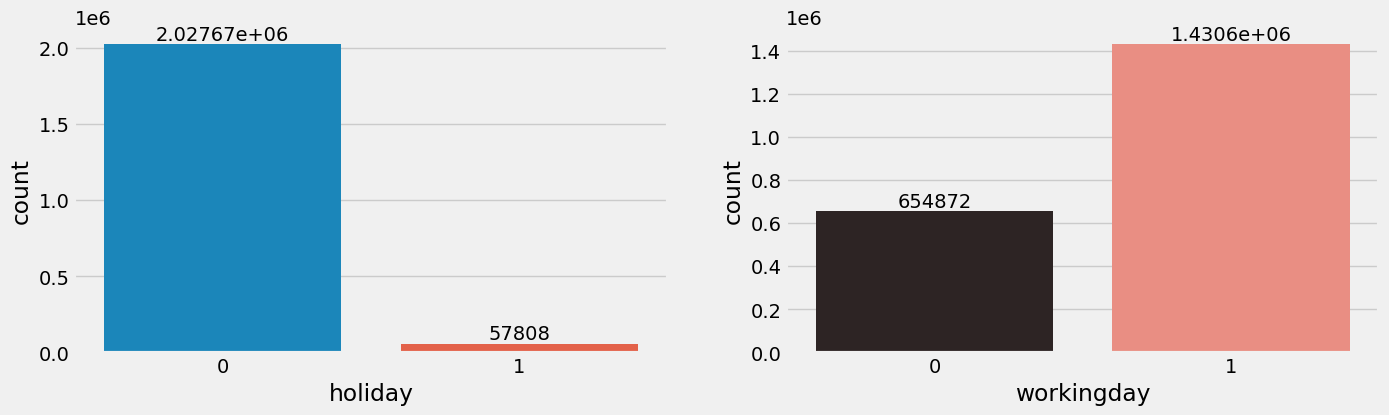

In [24]:
# Plot showing relation between holiday vs. count and workingday vs. count
f, ax = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x='holiday', y='count', data=df, ci=None, ax=ax[0], estimator=sum)
sns.barplot(x='workingday', y='count', data=df, ax=ax[1], ci=None, palette='dark:salmon', estimator=sum)
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
plt.show()

- Working day has higest demand.

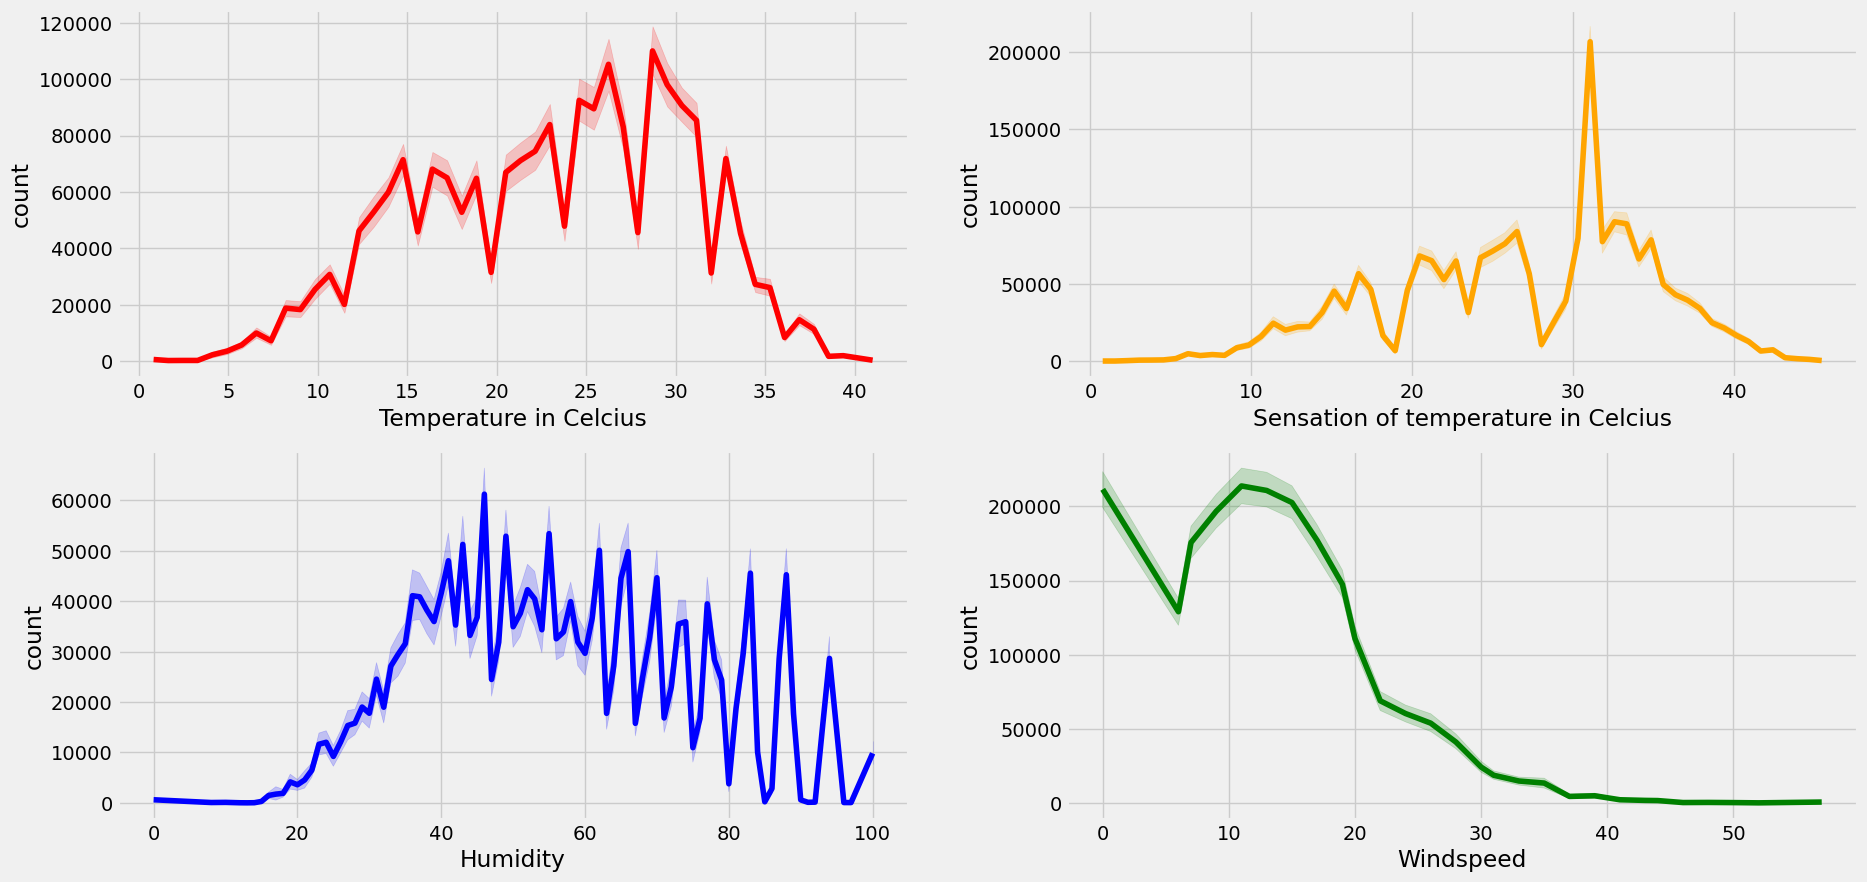

In [25]:
f, ax = plt.subplots(2, 2, figsize=(20,10))
sns.lineplot(x='temp', y='count', data=df.reset_index(), ax=ax[0][0], color='red', estimator=sum)
sns.lineplot(x='atemp', y='count', data=df.reset_index(), ax=ax[0][1], color='orange', estimator=sum)
sns.lineplot(x='humidity', y='count', data=df.reset_index(), ax=ax[1][0], color='blue', estimator=sum)
sns.lineplot(x='windspeed', y='count', data=df.reset_index(), ax=ax[1][1], color='green', estimator=sum)
ax[0][0].set_xlabel('Temperature in Celcius')
ax[0][1].set_xlabel('Sensation of temperature in Celcius')
ax[1][0].set_xlabel('Humidity')
ax[1][1].set_xlabel('Windspeed')
plt.show()

- When temperature feels around 30 degrees, humidity around 50 and windspeed between 8 and 15 showing highest demand.

# Feature relationship

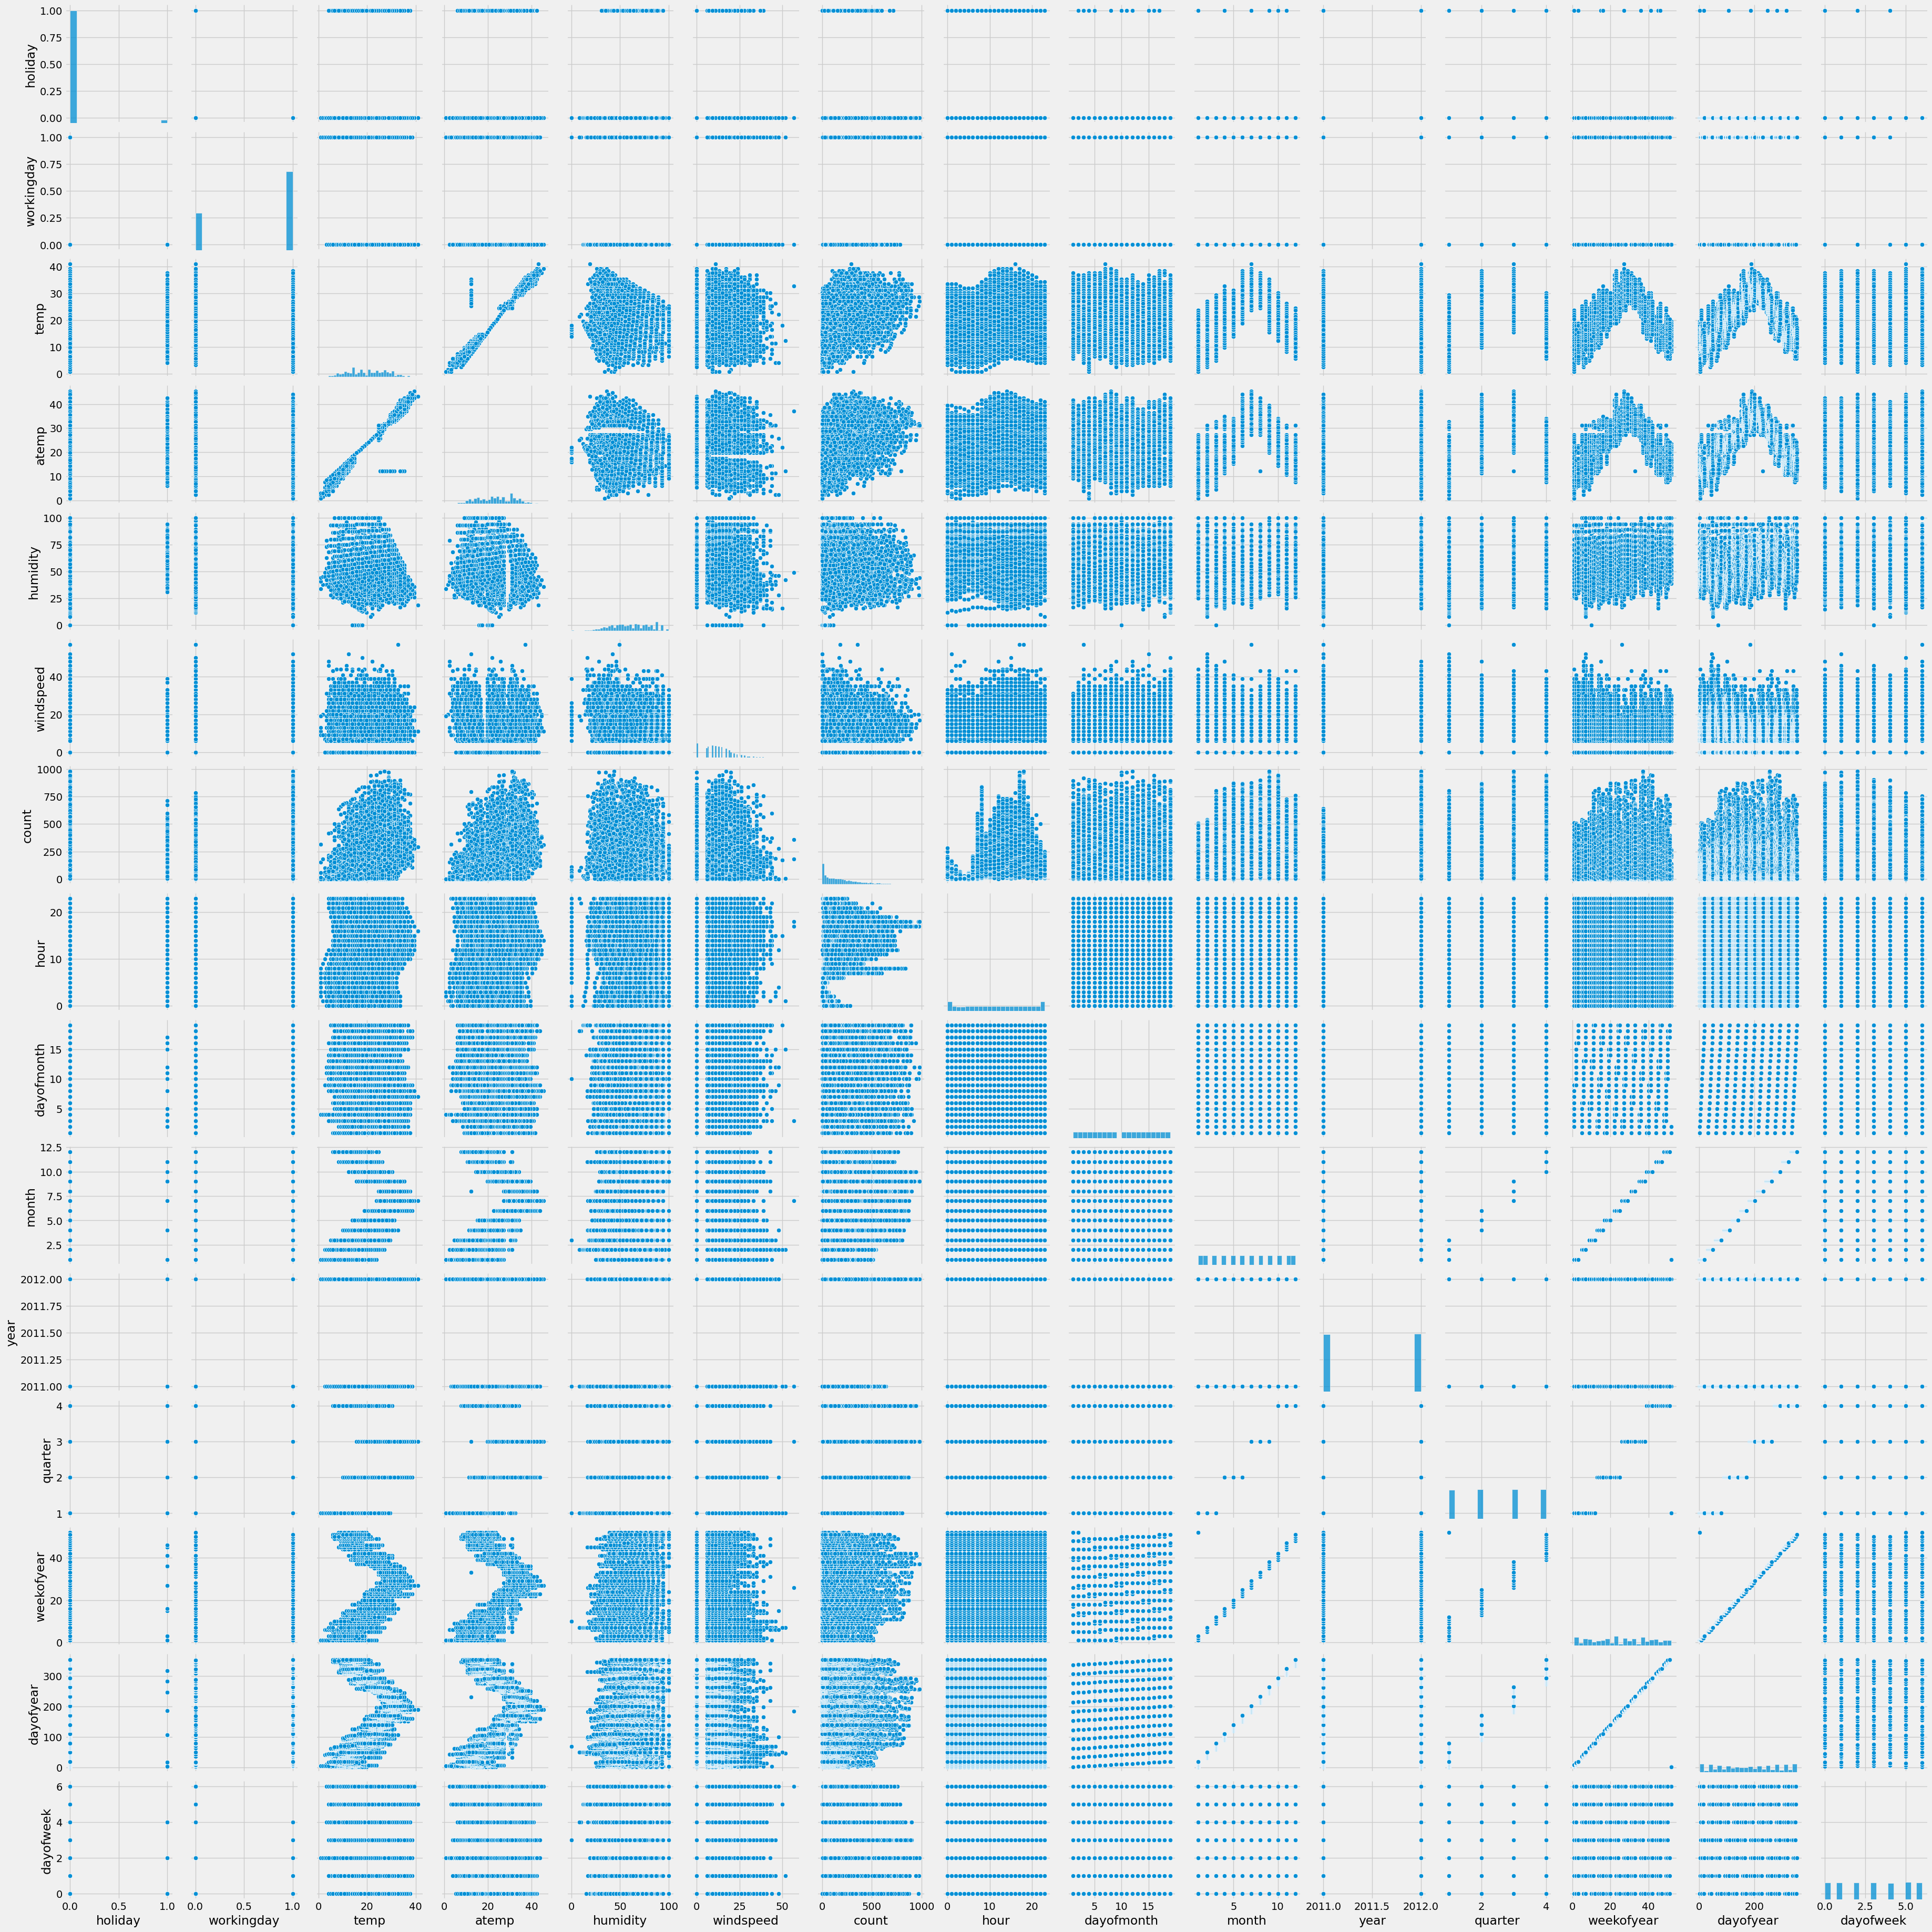

In [26]:
# Showing relationship between variables using pair plot
_ = sns.pairplot(data=df.reset_index())

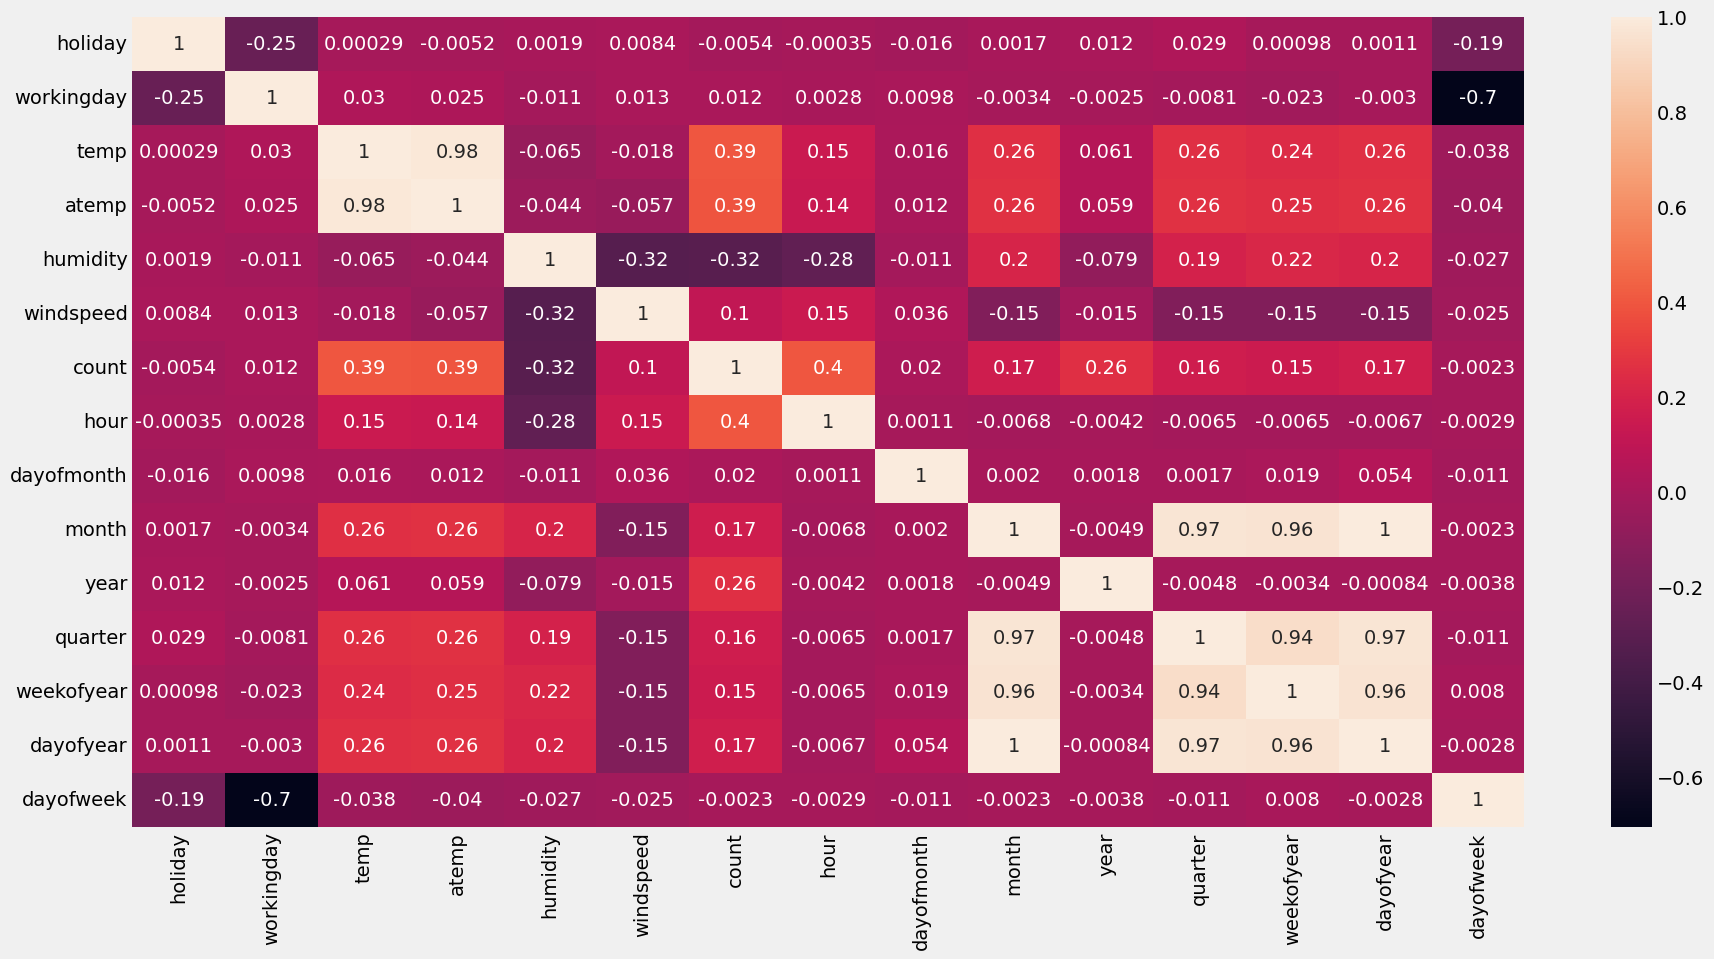

In [27]:
# Correlation between features
plt.figure(figsize=(20,10))
_ = sns.heatmap(df.corr(), annot=True)

- From heatmap correlation, temp and atemp showing very high corelation. Also, Weekofyear, quarter, dayofyear showing high co-relation with month.

# Feature selection 

In [28]:
# Calculate the VIF and selection the feature with low VIF
cols_for_vif = ['holiday','workingday','temp','atemp','humidity','windspeed','hour','dayofmonth','month','year','weekofyear','quarter','dayofyear','dayofweek']
X = df[cols_for_vif]
df_vif = pd.DataFrame()
df_vif['feature'] = X.columns
df_vif['value'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
df_vif.sort_values(by='value', ascending=False)

feature          value
8        month  107505.271695
12   dayofyear   90963.897161
9         year    2011.895012
3        atemp     315.961412
7   dayofmonth     281.706671
2         temp     276.795840
11     quarter     110.201438
10  weekofyear      55.000163
4     humidity      14.381542
13   dayofweek       9.205217
1   workingday       9.102880
6         hour       4.208648
5    windspeed       4.097616
0      holiday       1.568728

# Feature engineering

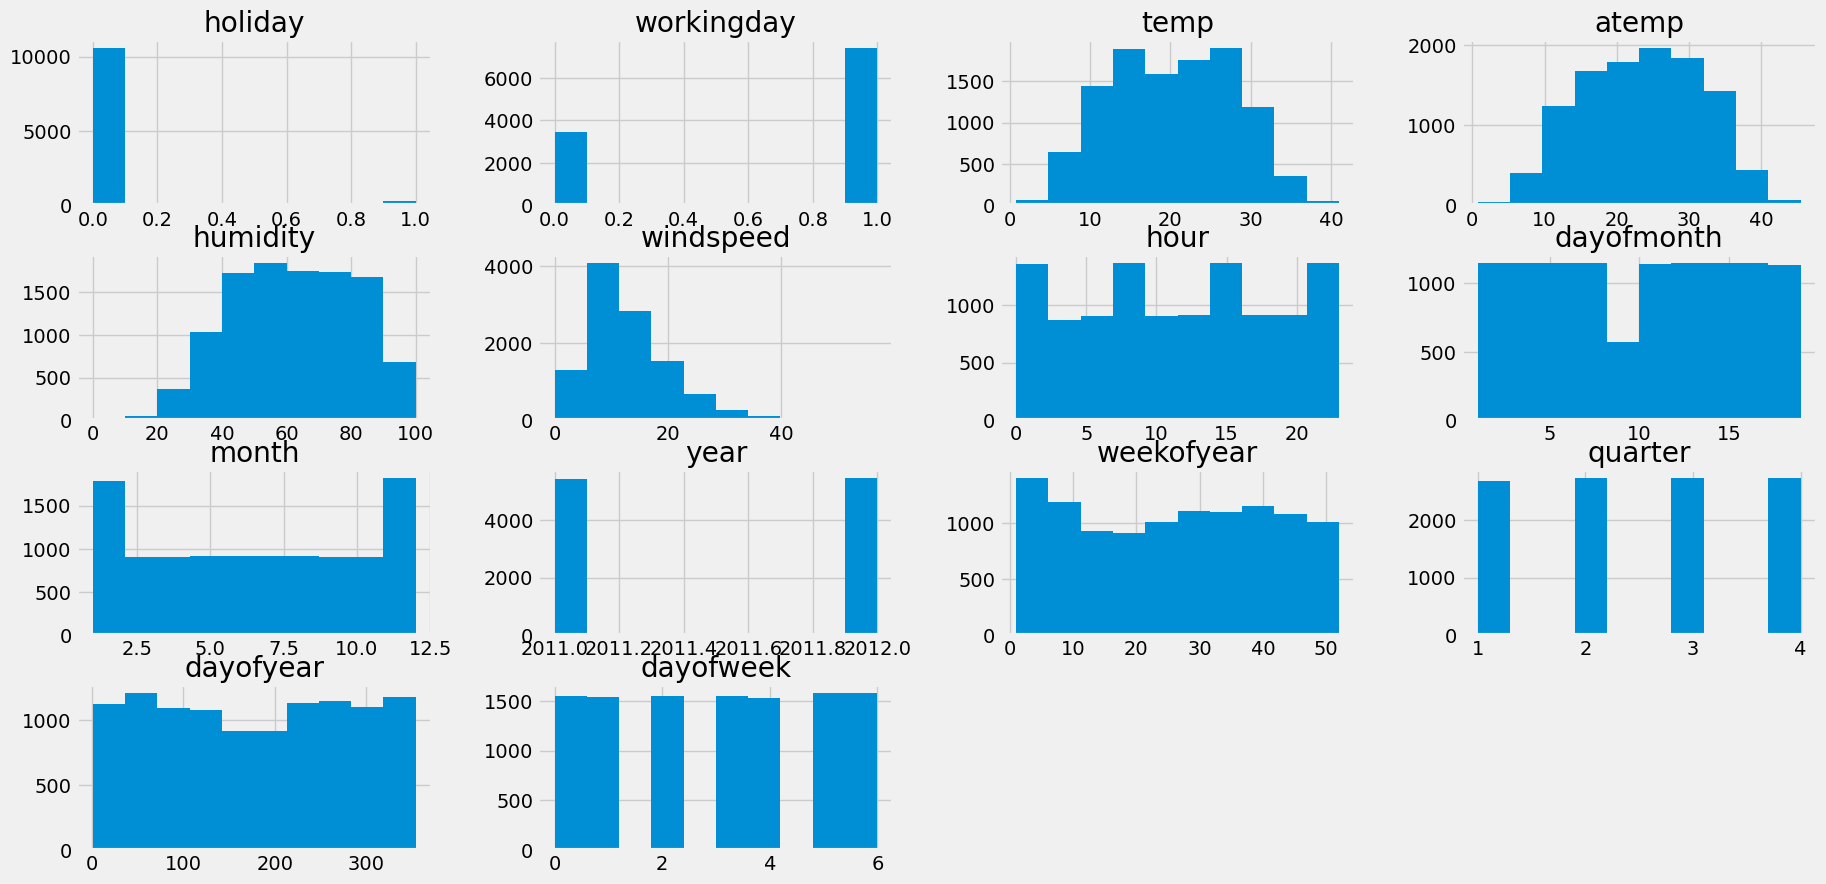

In [29]:
# Overview of data distribution
_ = df[cols_for_vif].hist(figsize=(20,10))

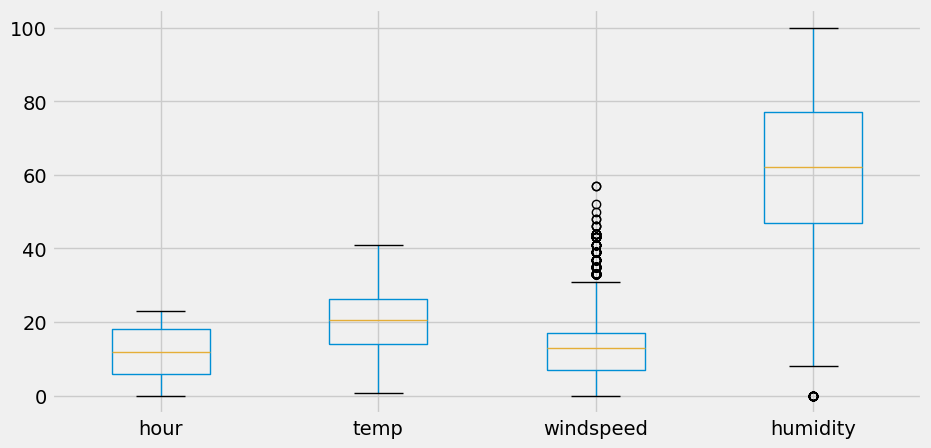

In [30]:
# To check the presence of outliers
_ = df[['hour','temp','windspeed','humidity']].boxplot(figsize=(10,5))

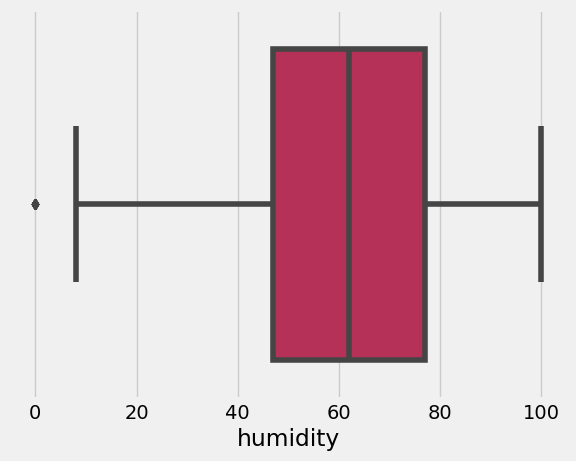

In [31]:
# Presence of outliers in humidity feature
_ = sns.boxplot(data=df, x='humidity', palette='rocket')

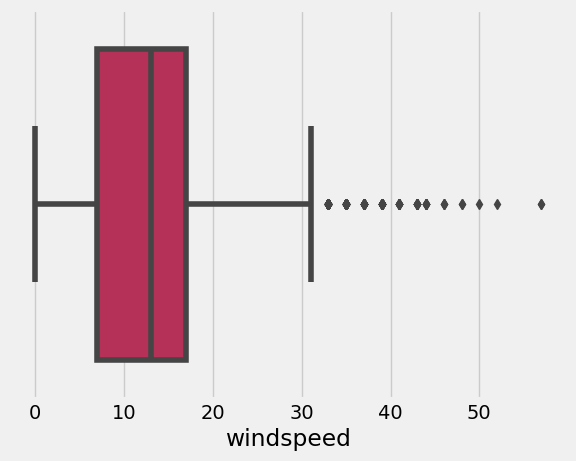

In [32]:
# Presence of outliers in windspeed feature
_ = sns.boxplot(data=df, x='windspeed', palette='rocket')

In [33]:
# Splitting into training and validation dataset

df_train = df.loc[df.index < '2012-07-01']
df_valid = df.loc[df.index >= '2012-07-01']

feature_to_train = ['month', 'hour', 'holiday','dayofweek', 'workingday', 'temp', 'humidity', 'windspeed','dayofmonth','season','weather',
                   'weekofyear','year']
X_train = df_train[feature_to_train]
X_valid = df_valid[feature_to_train]

y_train = df_train['count']
y_valid = df_valid['count']

In [34]:
# Performed StandardScaler
ss = StandardScaler()
ss_train = pd.DataFrame(ss.fit_transform(X_train[['temp']]))
ss_valid = pd.DataFrame(ss.transform(X_valid[['temp']]))

ss_train.index = X_train.index
ss_train.columns = ['temp']

ss_valid.index = X_valid.index
ss_valid.columns = ['temp']

X_train.loc[:,'temp'] = ss_train.loc[:,'temp']
X_valid.loc[:,'temp'] = ss_valid.loc[:,'temp']


C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\2065022766.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'temp'] = ss_train.loc[:,'temp']
C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\2065022766.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.loc[:,'temp'] = ss_valid.loc[:,'temp']


In [35]:
# Performed Powertransformer
pt = PowerTransformer()
pt_train = pd.DataFrame(pt.fit_transform(X_train[['humidity','windspeed']]))
pt_valid = pd.DataFrame(pt.transform(X_valid[['humidity','windspeed']]))

pt_train.index = X_train.index
pt_train.columns = ['humidity','windspeed']

pt_valid.index = X_valid.index
pt_valid.columns = ['humidity','windspeed']

X_train[['humidity','windspeed']] = pt_train[['humidity','windspeed']]
X_valid[['humidity','windspeed']] = pt_valid[['humidity','windspeed']]

C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\1772161856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['humidity','windspeed']] = pt_train[['humidity','windspeed']]
C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\1772161856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[['humidity','windspeed']] = pt_valid[['humidity','windspeed']]


In [36]:
# Performing OneHotEncoding on non-ordinal features
ohe_pipe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = pd.DataFrame(ohe_pipe.fit_transform(X_train[['season']]))
X_valid_ohe = pd.DataFrame(ohe_pipe.transform(X_valid[['season']]))

X_train_ohe.columns = ohe_pipe.get_feature_names_out()
X_train_ohe.index = X_train.index

X_valid_ohe.columns = ohe_pipe.get_feature_names_out()
X_valid_ohe.index = X_valid.index

In [37]:
# Performing OrdinalEncoding on ordinal features
oe_pipe = OrdinalEncoder(categories=[['good', 'better', 'best', 'worst']], handle_unknown='error')
X_train_oe = pd.DataFrame(oe_pipe.fit_transform(X_train[['weather']]))
X_valid_oe = pd.DataFrame(oe_pipe.transform(X_valid[['weather']]))

X_train_oe.columns = oe_pipe.feature_names_in_
X_valid_oe.columns = oe_pipe.feature_names_in_

X_train_oe.index = X_train.index
X_valid_oe.index = X_valid.index

In [38]:
X_train.drop(['season','weather'], axis=1, inplace=True)
X_valid.drop(['season','weather'], axis=1, inplace=True)

C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\3042435827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['season','weather'], axis=1, inplace=True)
C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\3042435827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.drop(['season','weather'], axis=1, inplace=True)


In [39]:
X_train = pd.concat([X_train, X_train_ohe, X_train_oe], axis=1)
X_valid = pd.concat([X_valid, X_valid_ohe, X_valid_oe], axis=1)

# Model training

In [40]:
# Dictionary of estimators
estimators = { 'LinearRegression' : LinearRegression(n_jobs=-1),
               'RandomForestRegressor': RandomForestRegressor(),
               'XGBRegressor': xgb.XGBRegressor()
             }

In [41]:
def get_prediction(estimators):
    """Train the models and get the score"""
    for name, model in estimators.items():
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_valid)
        y_train_pred = model.predict(X_train)
        
        print(f'Train MAE: {name}  {mean_absolute_error(y_train, y_train_pred)}')
        print(f'Train MSE: {name}  {mean_squared_error(y_train, y_train_pred)}')
        print(f'Train R2: {name}  {r2_score(y_train, y_train_pred)}')

        print(30*'-')

        print(f'Val MAE: {name}  {mean_absolute_error(y_valid, y_pred)}')
        print(f'Val MSE: {name}  {mean_squared_error(y_valid, y_pred)}')
        print(f'Val R2: {name}  {r2_score(y_valid, y_pred)}')
        
        print(60*'#', end='\n')

In [42]:
# Getting score form different models
get_prediction(estimators)

Train MAE: LinearRegression  93.41810066282802
Train MSE: LinearRegression  15493.655873244996
Train R2: LinearRegression  0.40156219767013523
------------------------------
Val MAE: LinearRegression  142.9661042465023
Val MSE: LinearRegression  33488.14893783877
Val R2: LinearRegression  0.2832378623004558
############################################################
Train MAE: RandomForestRegressor  8.091086983192247
Train MSE: RandomForestRegressor  175.24281473438842
Train R2: RandomForestRegressor  0.9932312989405655
------------------------------
Val MAE: RandomForestRegressor  50.1196563071298
Val MSE: RandomForestRegressor  6382.701405484459
Val R2: RandomForestRegressor  0.8633881283738648
############################################################
Train MAE: XGBRegressor  12.200175055801875
Train MSE: XGBRegressor  322.66239255581127
Train R2: XGBRegressor  0.9875372620461361
------------------------------
Val MAE: XGBRegressor  47.44223127994393
Val MSE: XGBRegressor  5183.2

- RandomForestRegressor and XGBRegressor gave the best result.

In [43]:
# XGBRegressor
xgbr = xgb.XGBRegressor(n_estimators=500,
                        early_stopping_rounds=10,
                        learning_rate=0.2)
xgbr.fit(X_train, y_train, 
         eval_set=[(X_train, y_train),(X_valid, y_valid)], 
         verbose=50)

[0]	validation_0-rmse:193.27556	validation_1-rmse:288.49093
[50]	validation_0-rmse:26.32596	validation_1-rmse:66.86892
[82]	validation_0-rmse:22.71186	validation_1-rmse:66.01055


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Model Evaluation

In [44]:
df_valid['pred'] = xgbr.predict(X_valid)
y_pred = xgbr.predict(X_valid)
y_train_pred = xgbr.predict(X_train)

print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred):.2f}')
print(f'Train MSE: {mean_squared_error(y_train, y_train_pred):.2f}')
print(f'Train R2: {r2_score(y_train, y_train_pred):.2f}')

print(30*'*')

print(f'Val MAE: {mean_absolute_error(y_valid, y_pred):.2f}')
print(f'Val MSE: {mean_squared_error(y_valid, y_pred):.2f}')
print(f'Val R2: {r2_score(y_valid, y_pred):.2f}')

Train MAE: 15.50
Train MSE: 548.08
Train R2: 0.98
******************************
Val MAE: 42.68
Val MSE: 4347.57
Val R2: 0.91


C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\2601000910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['pred'] = xgbr.predict(X_valid)


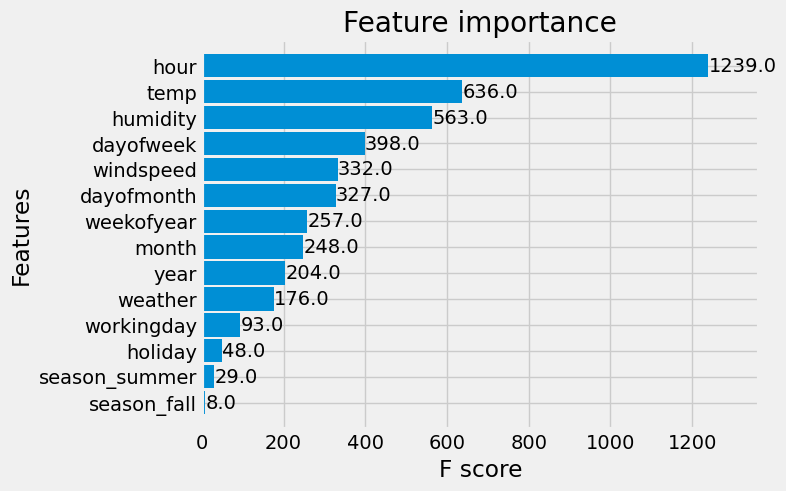

In [45]:
# Plotting feature importance
_ = plot_importance(xgbr, height=0.9)

# Cross validation

In [46]:
# Preparing data for cross validation
feature_to_train = ['month', 'hour', 'holiday','dayofweek', 'workingday', 'temp', 'humidity', 'windspeed','dayofmonth','season','weather',
                   'weekofyear','year']
X_train = df[feature_to_train]
y_train = df['count']

# Encoding categorical variables
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[['season']]))
X_train_ohe.columns = ohe.get_feature_names_out()
X_train_ohe.index = X_train.index

oe = OrdinalEncoder(categories=[['good', 'better', 'best', 'worst']], handle_unknown='error')
X_train_oe = pd.DataFrame(oe.fit_transform(X_train[['weather']]))
X_train_oe.columns = oe.feature_names_in_
X_train_oe.index = X_train.index

X_train.drop(['season','weather'], axis=1, inplace=True)
X_train = pd.concat([X_train, X_train_ohe, X_train_oe], axis=1)

# Scaling numerical variables
ss = StandardScaler()
ss_train = pd.DataFrame(ss.fit_transform(X_train[['temp']]))

ss_train.index = X_train.index
ss_train.columns = ['temp']

X_train['temp'] = ss_train['temp']

pt = PowerTransformer()
pt_train = pd.DataFrame(pt.fit_transform(X_train[['humidity','windspeed']]))

pt_train.index = X_train.index
pt_train.columns = ['humidity','windspeed']

X_train[['humidity','windspeed']] = pt_train[['humidity','windspeed']]



C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\1794076208.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['season','weather'], axis=1, inplace=True)


In [47]:
# Testing score on cross validation
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=4)

for i, (tr_idx, val_idx) in enumerate(tss.split(X_train)):
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    model = xgb.XGBRegressor(n_estimators=500,
                        early_stopping_rounds=10,
                        learning_rate=0.2)
    model.fit(X_tr, y_tr, 
         eval_set=[(X_tr, y_tr),(X_val, y_val)],
             verbose=0)
    
    y_train_pred = xgbr.predict(X_tr)
    print(f'Train R2: {i} {r2_score(y_tr, y_train_pred):.2f}')
    
    y_pred = model.predict(X_val)
    print(f'Val R2: {i} {r2_score(y_val, y_pred):.2f}')
    
    print('#'*50)

Train R2: 0 0.96
Val R2: 0 0.84
##################################################
Train R2: 1 0.97
Val R2: 1 0.64
##################################################
Train R2: 2 0.97
Val R2: 2 0.78
##################################################
Train R2: 3 0.96
Val R2: 3 0.91
##################################################


# Forcast on validation set

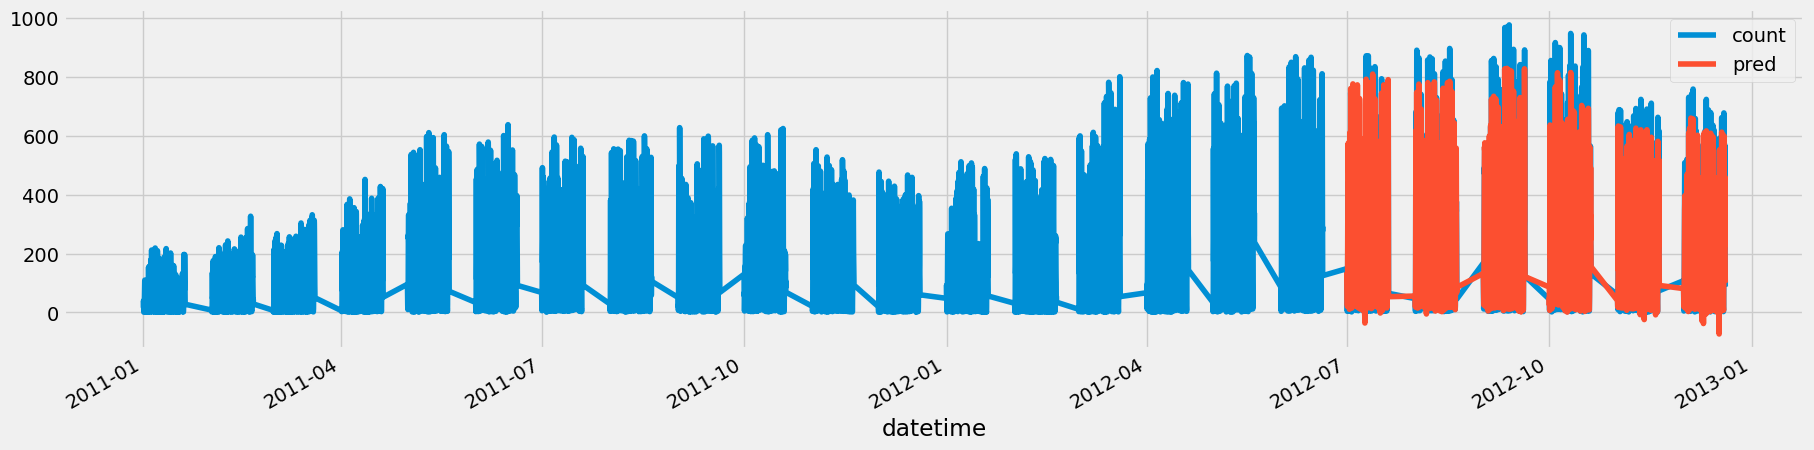

In [48]:
df_all = pd.concat([df_train,df_valid])
_ = df_all[['count','pred']].plot(figsize=(20,5))

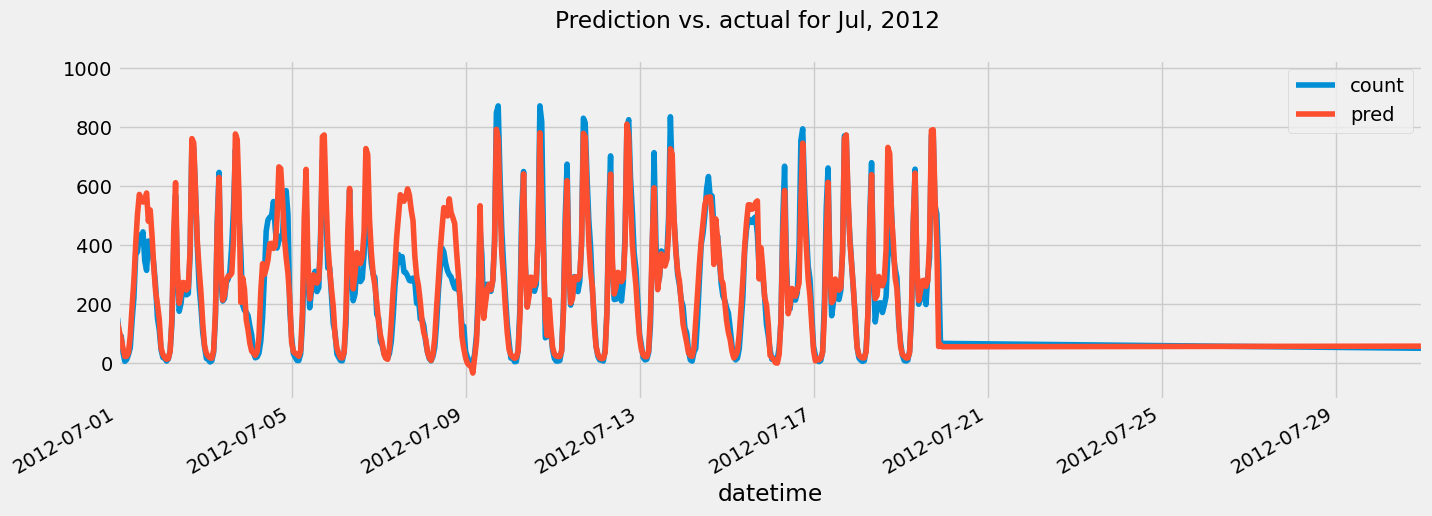

In [49]:
# plot the forcast with actual for first month i.e., July, 2012
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['count','pred']].plot(ax=ax, style=['-','-'])
ax.set_xbound(lower='01-Jul-2012', upper='31-Jul-2012')
_ = plt.suptitle('Prediction vs. actual for Jul, 2012')

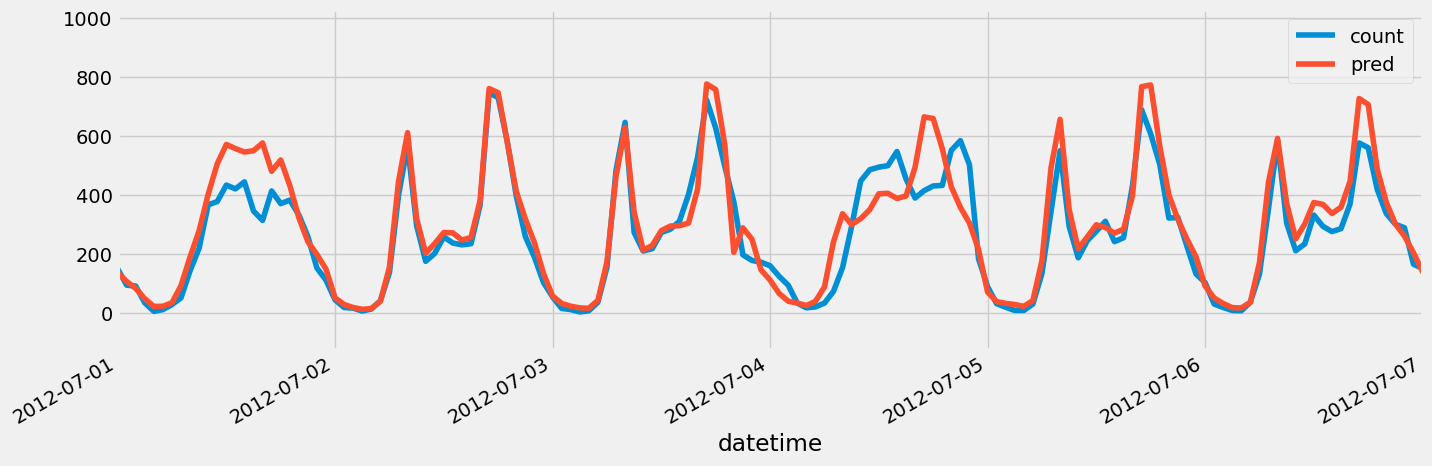

In [50]:
# plot the forcast for first week
f, ax = plt.subplots(1,figsize=(15,5))
df_all[['count', 'pred']].plot(ax=ax)
ax.set_xbound(lower='2012-07-01', upper='2012-07-07')
plt.show()

# Analysing the best and worst predicted days

In [51]:
df_all['error'] = df_all['count'] - df_all['pred']
df_all['abs_error'] = df_all['error'].apply(np.abs)

In [52]:
error_by_day = df_all.groupby(['year','month','dayofmonth'])[['count','pred','error','abs_error']].mean()

In [53]:
# Overforcasted days
error_by_day.sort_values(by='error').head(10)

count        pred       error   abs_error
year month dayofmonth                                                
2012 7     7           201.666667  314.571259 -112.904605  114.494656
           8           194.666667  265.687225  -71.020573   82.771960
           1           230.458333  293.713928  -63.255592   67.231086
     8     19          189.541667  246.606003  -57.064338   83.925796
     7     6           258.625000  304.351074  -45.726070   49.049848
     8     5           227.666667  271.039520  -43.372854   47.795072
     7     18          238.041667  280.118744  -42.077089   55.191306
           5           260.041667  298.951813  -38.910135   45.654174
     9     1           255.833333  288.599792  -32.766461   51.023013
     8     4           284.333333  313.670959  -29.337632   37.292359

In [54]:
# Worst predicted days
error_by_day.sort_values(by='abs_error', ascending=False).head(10)

count        pred       error   abs_error
year month dayofmonth                                                
2012 7     7           201.666667  314.571259 -112.904605  114.494656
           4           308.458333  300.280182    8.178146  106.481000
     10    2           193.291667  158.830734   34.460927  103.773649
     9     3           251.416667  260.104797   -8.688137   96.470833
     8     19          189.541667  246.606003  -57.064338   83.925796
     7     8           194.666667  265.687225  -71.020573   82.771960
     12    17          191.041667  137.282196   53.759476   69.568550
     7     1           230.458333  293.713928  -63.255592   67.231086
     12    10          215.416667  161.208939   54.207735   64.318819
     10    17          310.875000  248.453934   62.421073   63.255657

In [55]:
# Best predicted days
error_by_day.sort_values(by='abs_error').head(10)

count        pred      error  abs_error
year month dayofmonth                                              
2012 12    15          210.291667  201.347122   8.944539  16.605657
     10    14          276.625000  271.070465   5.554525  17.666272
     7     2           259.458333  280.329773 -20.871441  21.268545
           17          282.750000  280.309448   2.440563  21.357847
     11    18          194.541667  176.015213  18.526457  22.864278
           17          234.541667  216.445328  18.096334  23.475162
     8     13          286.791667  266.309326  20.482328  23.715447
           17          297.833333  284.860016  12.973315  24.536710
     12    19          219.458333  209.024094  10.434241  25.107340
     8     3           298.958333  283.731659  15.226680  25.477753

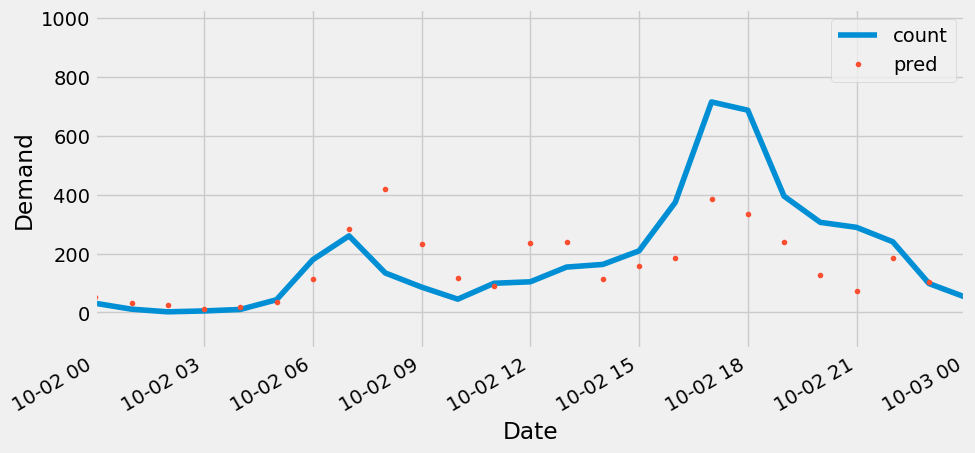

In [56]:
# Plotting worst predicted day
ax = df_all[['count','pred']].plot(style=['-','.'], figsize=(10,5))
ax.set_ylabel('Demand')
ax.set_xlabel('Date')
ax.set_xbound(lower='2012-10-02', upper='2012-10-03')
plt.show()

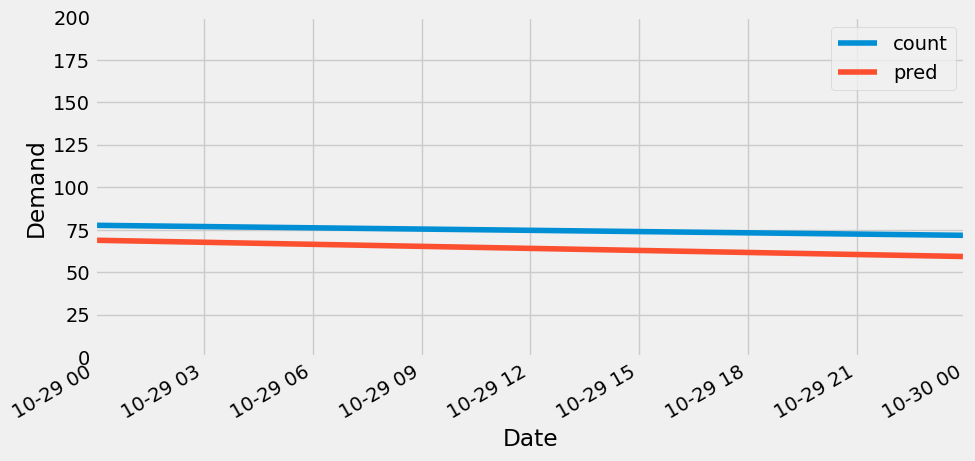

In [57]:
# Plotting best predicted day
ax = df_all[['count','pred']].plot(style=['-','-'], figsize=(10,5))
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
ax.set_xbound(lower='2012-10-29', upper='2012-10-30')
ax.set_ylim(0,200)
plt.show()

# Predicting the demand on test dataset

In [58]:
test_file_path = os.path.join(DIR,'Lyftdataset_test.csv')
test_df = pd.read_csv(test_file_path, parse_dates=['datetime'], index_col='datetime')
test_df = date_feature_creation(test_df)
test_df = test_df[feature_to_train]
test_df['season'] = test_df['season'].map(lambda x: seasons[x])
ohe_test = pd.DataFrame(ohe.transform(test_df[['season']]))
ohe_test.index = test_df.index
ohe_test.columns = ohe.get_feature_names_out()
test_df.drop(['season'], axis=1, inplace=True)
test_df = pd.concat([test_df,ohe_test], axis=1)

C:\Users\ianra\AppData\Local\Temp\ipykernel_10236\2809620696.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_feature['weekofyear'] = df_feature.index.weekofyear


In [59]:
feat = ['month', 'hour', 'holiday', 'dayofweek', 'workingday', 'temp',
        'humidity', 'windspeed', 'dayofmonth', 'weekofyear', 'year',
        'season_fall', 'season_spring', 'season_summer', 'season_winter',
        'weather']
test_df = test_df[feat]
test_df.columns

Index(['month', 'hour', 'holiday', 'dayofweek', 'workingday', 'temp',
       'humidity', 'windspeed', 'dayofmonth', 'weekofyear', 'year',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'weather'],
      dtype='object')

In [60]:
test_df['pred'] = xgbr.predict(test_df)

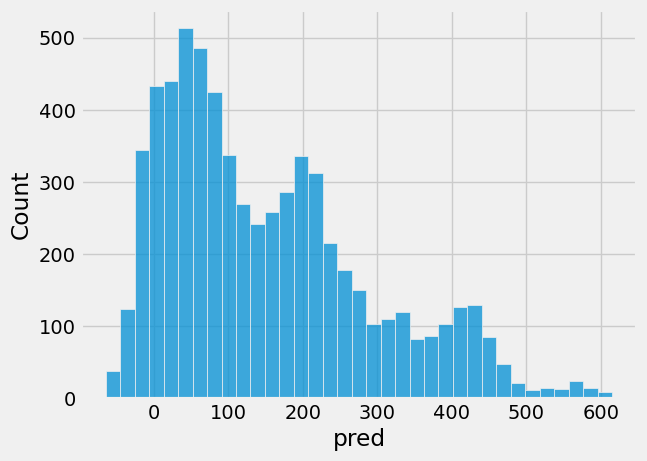

In [61]:
sns.histplot(test_df['pred'])
plt.show()

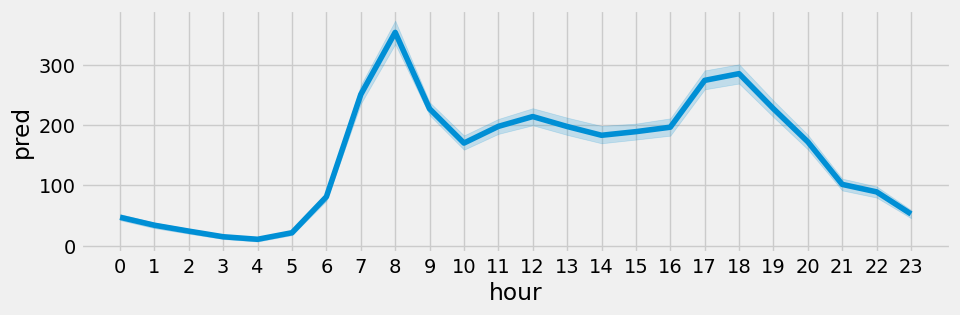

In [62]:
plt.figure(figsize=(10,3))
sns.lineplot(data=test_df, x='hour', y='pred')
plt.xticks(test_df['hour'].unique())
plt.show()

# The end